# Recommendation system model training

## Table of contents

1. Modeling techniques considered
2. Model selection criteria
3. Description of chosen model
4. Model implementation, performance metrics and intepretation
5. Model implementation, performance metrics and intepretation for the other scenarios
6. Evaluation of model performance against business objectives
7. Limitations of the current approach
8. Suggestions for model improvements

## 1) Modelling techniques considered

Given that the task is to find out which product we should prioritise showing to customers we decided to treat it as a classification problem, where we need to predict the likelihood of a customer wanting each product (hereby referred to as the desirability of the product). The approach we will take is if a customer does not have a product but the model believes a product is highly desireable to an inidividual, we will market that product to the customer. Hence after using machine learning to find out the desirability of all products, we will rank the products according to their desirability and prioritise the most desire product, if the customer does not have this product yet. The rationale behind this is that if a customer already has a product it would be a waste of resources to market the same exact product to the customer again.     
This method is also referred to as a pointwise learning to rank approach, and it excels as it is simple, flexible, and efficient for use in large datasets, like the ones that we will work with in a bank.  

Given that we can leverage bank data and the dataset we are working with has clear labels (after translation), it would be best to use supervised learning. 
The list of models we considered that are supervised learning and handle classification tasks include the following models:  

- Logistic Regression: Predicts the likelihood of something happening  
- Decision Tree: Makes decisions based on a series of questions (like a flowchart)  
- Random Forest: Combines many decision trees for more accurate predictions  
- Support Vector Machines: Finds the best way to divide data into groups  
- Neural Network: Learns patterns like the human brain  
- Gradient Boosting: Improves predictions by learning from mistakes.  


## 2) Model selection criteria

We start by considering the context of our dataset and our task:  
1. The bank dataset is very large. While we are using a smaller subset of this dataset for our project, the model must be able to accomodate a large dataset   
2. We want to market to customers who actually want our product. If a customer has a low desirability score for all products, we should have a way of noticing that. This will tell us which customers to prioritise marketing to. This means we should use a model should not solely produce a ranking, but also produce a desirability score (from 0 to 1) that shows the probability the customer would want a product.  
3. The model should also be easy to intepret, a key purpose of this project is to gain insight about customer purchasing patterns.   

Based on these criteria, <u>we chose Logistic Regression</u>.    

**Why logistic regression?**  
- Handles Large Datasets: Logistic Regression is computationally efficient and can handle large datasets like those we would have from a bank.
- Produces Probability Scores: It directly outputs probabilities (between 0 and 1), which can be interpreted as desirability scores.  
- Interpretability: Logistic Regression models are relatively easy to interpret. Coefficients associated with each feature can provide insights into the importance of different factors influencing the outcome.  

**Why not the other models?**  
- Decision Trees, Random Forests, and Gradient Boosting: While these models can be highly accurate, they can be less interpretable, especially as they become more complex.  
- Support Vector Machines: While effective for classification, they might not be as efficient for large datasets and can be less interpretable.  
- Neural Networks: While powerful, neural networks can be complex and difficult to interpret, especially for smaller datasets. They can also be computationally expensive to train.  
- In conclusion, Logistic Regression provides a good balance of accuracy, efficiency, and interpretability, making it a suitable choice for the given task and dataset.  

## 3) Description of chosen model

Logistic Regression is a machine learning model we can use to predict the probability of an event, providing an output between 0 and 1. In the context of this task it is calculating the probability a customer wants a particular product based on information about them, we will do this for all products in the bank.

**How It Works:**  
- Weighted Features and Likeliness Values: Logistic Regression takes each feature (such as customer income or age) and multiplies it by a weight specific to that feature, producing a "likelihood factor." These likelihood factors represent how much each feature contributes to the final probability. All likelihood factors are then summed, forming a combined value that represents the overall likelihood that a customer would want the product.

**Sigmoid Function:**  
- This combined likelihood value is passed through the sigmoid function, which "squeezes" it into a range between 0 and 1:

**Adjusting Weights:**  
- During training, the weights are adjusted to minimize the difference between predicted desirability scores and actual customer interest. This helps the model to learn more accurately which features are most relevant for predicting product desirability

**Now that the purpose and rationale behind the model has been explained, this is how we will implement the logistic regression model:**  
- For each product one logistic regression model is dedicated to calculate the desirability of that product, this is done for all products.
The desirability is ranked from highest to lowest in a list. Next we go down the list and check if the customer already has the product, if they do we skip that product and go to the next most desirable product. The final result is a list of products that we would recommend to a customer in order of ranking.

## 4) Model implementation, performance metrics and intepretation

This involves a few parts:
1. Imports and loading in data
2. Creation of balanced training data
3. Training and testing of model, and printing evaluation metrics 
4. Finding features that are key to customer decision

### 4.1) Import relevant libraries and loading in data


In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
import warnings
import matplotlib.pyplot as plt


### Loading in data used. This will be done 3 times, for 3 datasets representing 3 scenarios

In [137]:
normal = 'clean_train_reco.csv'
covid = 'clean_train_reco_covid.csv'
meteor= 'clean_train_reco_meteor.csv'

normal_test = 'clean_test_reco.csv'
covid_test = 'clean_test_reco_covid.csv'
meteor_test = 'clean_test_reco_meteor.csv'

df_train = pd.read_csv(normal)
df_covid_train = pd.read_csv(covid)
df_meteor_train = pd.read_csv(meteor)

df_test = pd.read_csv(normal_test)
df_covid_test = pd.read_csv(covid_test)
df_meteor_test = pd.read_csv(meteor_test)

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, message=".*ConvergenceWarning.*")


## 4.2) Creation of balanced datasets for training the model
The original datasets was created with the concern of balancing 4 binary columns, that means 4*2 = 8 classes to balance in total. As such a 50/50/50/50/50/50/50/50 split is impossible and instead the aim was to ensure there was enough samples containing values of each class. This way we can create a subset of training data where we select equal amounts of each class to achieve a 50/50 split for only one binary column, which is fine because we are training and evaluating 4 logistic regression models, one for each product.

In [138]:
# Function to balance datasets by selecting 5000 samples for each binary column class (0 and 1)
def create_balanced_datasets(df, binary_columns = ['fixed_deposits', 'loan', 'credit_card_debit_card', 'account'], sample_size=5000):
    balanced_datasets = {}
    
    for column in binary_columns:
        
        # Check if there are enough samples of each class
        if df[column].value_counts().get(0, 0) < sample_size or df[column].value_counts().get(1, 0) < sample_size:
            print(f"Warning: Not enough samples to balance {column}. Skipping.")
            continue
        
        # Sample 5000 rows for each class (0 and 1)
        df_class_0 = df[df[column] == 0].sample(n=sample_size, random_state=42)
        df_class_1 = df[df[column] == 1].sample(n=sample_size, random_state=42)
        
        # Concatenate the samples and shuffle
        balanced_df = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Store in dictionary with the column name as the key
        balanced_datasets[column] = balanced_df
    
    return balanced_datasets

balanced_train = create_balanced_datasets(df_train)
balanced_covid_train = create_balanced_datasets(df_covid_train)
balanced_meteor_train = create_balanced_datasets(df_meteor_train)


### 4.3) Training and testing of model, and printing evaluation metrics 

1. What performance metric(s) to use to assess the model? 
2. How to optimise model performance?
  
**(1) What performance metric to use to assess the model?**   
- We used Recall (aka True Positive Rate) for 'fixed_deposits', 'loan', 'credit_card_debit_card', and True Negative Rate for 'account'. We will also provide accuracy as a measurement of overall model performance. The justification behind this will be in section 6: Choice of performance metrics to fit business objectives

**(2) How to optimise model performance?**  
- Short answer: We use hyperparameter tuning.  
- Long answer:  
     Model optimization by hyperparameter tuning involves adjusting the settings (hyperparameters) of a model to improve its performance. Hyperparameters are configurations that control the learning process but are not learned from the data itself. By tuning them, we can find the best combination that leads to higher accuracy or better performance on our chosen metric.

     For logistic regression, hyperparameter tuning typically involves adjusting settings like:
     - C: Controls how much the model should focus on fitting the data; lower values make it simpler.
     penalty: Determines how the model handles complexity ('l1' for Lasso, 'l2' for Ridge).
     solver: Specifies the method used to find the best solution (e.g., 'liblinear', 'saga').
     max_iter: Sets the maximum number of attempts the model can make to find the solution

     - These hyperparameters can be tuned using methods like grid search or randomized search to find the best configuration for the model.  

     In addition to these settings, we can adjust the threshold that determines if the model predicts a customer will buy a product or not. This helps improve the results. During training, it's important for the model to give a clear "yes" or "no" answer so it can be judged as either correct or wrong. Changing the threshold affects the model's performance, with some thresholds improving certain metrics while others make them worse. We can plot these changes to find the best balance between accuracy and the chosen metric.




Training and evaluating model for fixed_deposits
Best parameters for fixed_deposits: {'penalty': 'l2', 'C': 0.001}
Recall for fixed_deposits at threshold 0.05: 1.0000
Accuracy for fixed_deposits at threshold 0.05: 0.4777
Recall for fixed_deposits at threshold 0.10: 1.0000
Accuracy for fixed_deposits at threshold 0.10: 0.6194
Recall for fixed_deposits at threshold 0.15: 0.9954
Accuracy for fixed_deposits at threshold 0.15: 0.7164
Recall for fixed_deposits at threshold 0.20: 0.9930
Accuracy for fixed_deposits at threshold 0.20: 0.7731
Recall for fixed_deposits at threshold 0.25: 0.9838
Accuracy for fixed_deposits at threshold 0.25: 0.8081
Recall for fixed_deposits at threshold 0.30: 0.9698
Accuracy for fixed_deposits at threshold 0.30: 0.8260
Recall for fixed_deposits at threshold 0.35: 0.9513
Accuracy for fixed_deposits at threshold 0.35: 0.8414
Recall for fixed_deposits at threshold 0.40: 0.9211
Accuracy for fixed_deposits at threshold 0.40: 0.8583
Recall for fixed_deposits at thresho

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


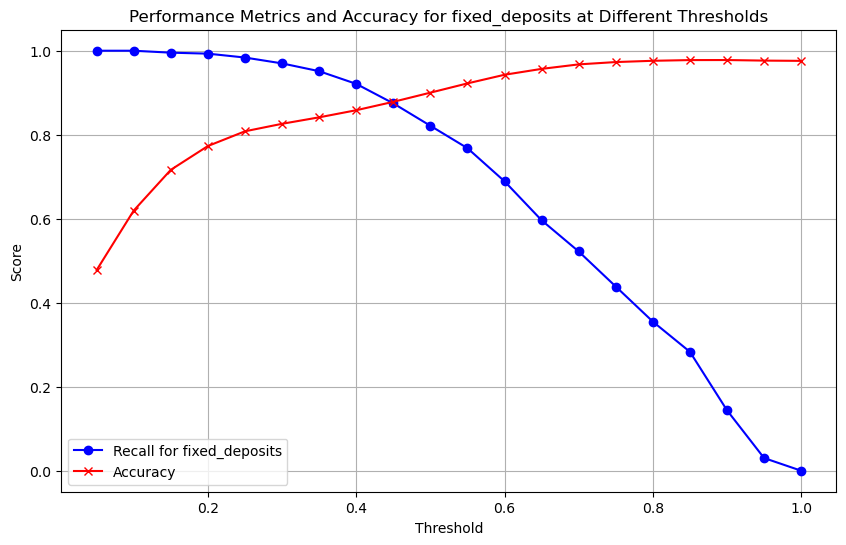

Evaluating model for fixed_deposits at fixed threshold 0.50
Confusion Matrix for fixed_deposits at threshold 0.50:
[[15719  1706]
 [   77   354]]
Recall for fixed_deposits at threshold 0.50: 0.8213
Accuracy for fixed_deposits at threshold 0.50: 0.9001

Training and evaluating model for loan
Best parameters for loan: {'penalty': 'l1', 'C': 0.001}
Recall for loan at threshold 0.05: 1.0000
Accuracy for loan at threshold 0.05: 0.0015
Recall for loan at threshold 0.10: 1.0000
Accuracy for loan at threshold 0.10: 0.0015
Recall for loan at threshold 0.15: 1.0000
Accuracy for loan at threshold 0.15: 0.0015
Recall for loan at threshold 0.20: 1.0000
Accuracy for loan at threshold 0.20: 0.5424
Recall for loan at threshold 0.25: 0.9259
Accuracy for loan at threshold 0.25: 0.6922
Recall for loan at threshold 0.30: 0.9259
Accuracy for loan at threshold 0.30: 0.7112
Recall for loan at threshold 0.35: 0.9259
Accuracy for loan at threshold 0.35: 0.7408
Recall for loan at threshold 0.40: 0.8889
Accuracy

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


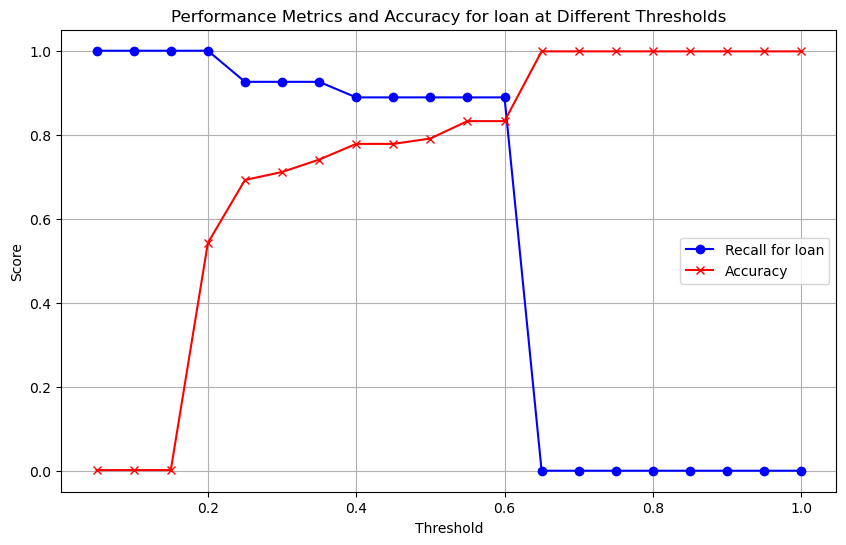

Evaluating model for loan at fixed threshold 0.50
Confusion Matrix for loan at threshold 0.50:
[[14099  3730]
 [    3    24]]
Recall for loan at threshold 0.50: 0.8889
Accuracy for loan at threshold 0.50: 0.7909

Training and evaluating model for credit_card_debit_card
Best parameters for credit_card_debit_card: {'penalty': 'l1', 'C': 0.001}
Recall for credit_card_debit_card at threshold 0.05: 1.0000
Accuracy for credit_card_debit_card at threshold 0.05: 0.1052
Recall for credit_card_debit_card at threshold 0.10: 1.0000
Accuracy for credit_card_debit_card at threshold 0.10: 0.1052
Recall for credit_card_debit_card at threshold 0.15: 1.0000
Accuracy for credit_card_debit_card at threshold 0.15: 0.1052
Recall for credit_card_debit_card at threshold 0.20: 1.0000
Accuracy for credit_card_debit_card at threshold 0.20: 0.1052
Recall for credit_card_debit_card at threshold 0.25: 0.9659
Accuracy for credit_card_debit_card at threshold 0.25: 0.7289
Recall for credit_card_debit_card at threshold

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


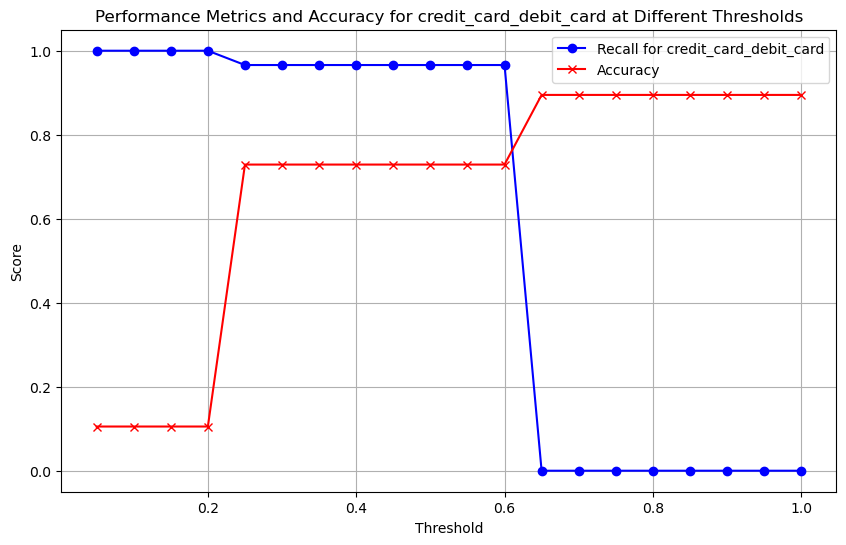

Evaluating model for credit_card_debit_card at fixed threshold 0.50
Confusion Matrix for credit_card_debit_card at threshold 0.50:
[[11201  4776]
 [   64  1815]]
Recall for credit_card_debit_card at threshold 0.50: 0.9659
Accuracy for credit_card_debit_card at threshold 0.50: 0.7289

Training and evaluating model for account
Best parameters for account: {'penalty': 'l2', 'C': 10}
Specificity for account at threshold 0.05: 0.0000
Accuracy for account at threshold 0.05: 0.9846
Specificity for account at threshold 0.10: 0.0000
Accuracy for account at threshold 0.10: 0.9845
Specificity for account at threshold 0.15: 0.0000
Accuracy for account at threshold 0.15: 0.9845
Specificity for account at threshold 0.20: 0.0000
Accuracy for account at threshold 0.20: 0.9845
Specificity for account at threshold 0.25: 0.0000
Accuracy for account at threshold 0.25: 0.9844
Specificity for account at threshold 0.30: 0.0000
Accuracy for account at threshold 0.30: 0.9843
Specificity for account at threshol

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


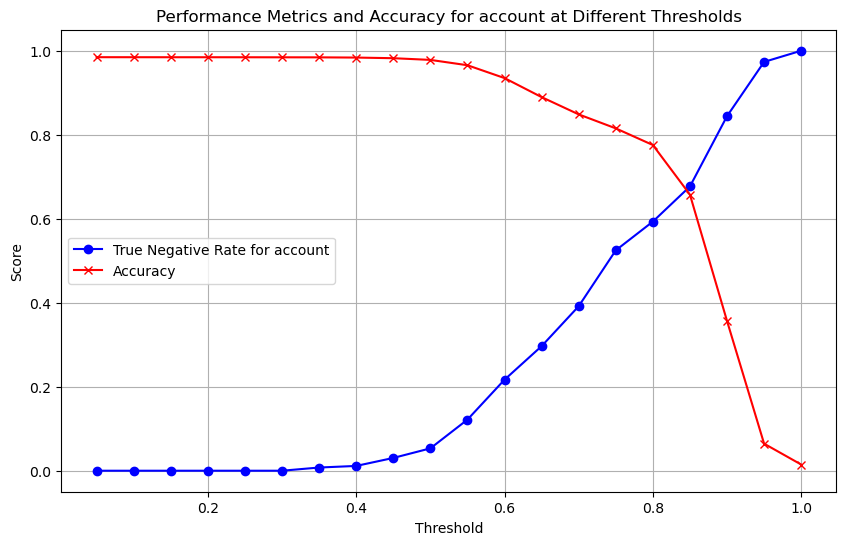

Evaluating model for account at fixed threshold 0.80
Confusion Matrix for account at threshold 0.80:
[[  156   107]
 [ 3902 13691]]
Specificity for account at threshold 0.80: 0.5932
Accuracy for account at threshold 0.80: 0.7755


In [139]:
def specificity_score(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Avoid division by zero
    return specificity
# Define the function to try different thresholds for logistic regression
def train_and_evaluate_models(datasets_dict, test_data, target_columns=['fixed_deposits', 'loan', 'credit_card_debit_card', 'account'], scoring_metric='recall', thresholds=None, account_threshold=0.8, other_threshold=0.5, weight_factor = 2):
    models = {}
    scaler = StandardScaler()

    if thresholds is None:
        thresholds = [i * 0.05 for i in range(1, 21)]  # Set thresholds between 0.05 and 1.0
    
    for column_name in target_columns:
        if column_name not in datasets_dict:
            print(f"Warning: No balanced dataset for {column_name}. Skipping.")
            continue

        print(f"\nTraining and evaluating model for {column_name}")
        
        # Get the dataset for this target column
        train_data = datasets_dict[column_name]
        
        # Split the train and test datasets into features (X) and target (y)
        X_train = train_data.drop(columns=target_columns)
        y_train = train_data[column_name]
        
        X_test = test_data.drop(columns=target_columns)
        y_test = test_data[column_name]
        
        # Scale features
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        # X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        if 'gross_income' in X_train_scaled.columns:
            X_train_scaled['gross_income'] *= weight_factor

        # Define logistic regression model
        lr_model = LogisticRegression(max_iter=100, class_weight='balanced', solver='liblinear')
        
        # Define hyperparameters for tuning
        param_dist = {
            'C': [0.001, 0.01, 0.1, 1, 10],  
            'penalty': ['l1', 'l2']
        }
        
        # Use StratifiedKFold for cross-validation
        skf = StratifiedKFold(n_splits=5)
        
        # Perform RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(lr_model, param_dist, n_iter=10, cv=skf, scoring=scoring_metric, n_jobs=-1)
        random_search.fit(X_train_scaled, y_train)
        
        # Store the best model
        models[column_name] = random_search.best_estimator_
        print(f"Best parameters for {column_name}: {random_search.best_params_}")
        
        # Get the probabilities for the positive class (1) for test set
        y_prob = random_search.predict_proba(X_test_scaled)[:, 1]
        
        # Initialize lists to store performance metrics and accuracy
        performance_metrics = []
        accuracies = []
        
        # Loop through all thresholds and evaluate performance
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            
            # Calculate the relevant metric
            if column_name == 'account':
                specificity = specificity_score(y_test, y_pred)
                performance_metrics.append(specificity)
                print(f"Specificity for {column_name} at threshold {threshold:.2f}: {specificity:.4f}")
                
                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)
                print(f"Accuracy for {column_name} at threshold {threshold:.2f}: {accuracy:.4f}")
            else:
                score = recall_score(y_test, y_pred)
                performance_metrics.append(score)
                print(f"{scoring_metric.capitalize()} for {column_name} at threshold {threshold:.2f}: {score:.4f}")
                
                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)
                print(f"Accuracy for {column_name} at threshold {threshold:.2f}: {accuracy:.4f}")
        
        # Plot the performance metrics and accuracy for each threshold
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, performance_metrics, label=f'{"True Negative Rate" if column_name == "account" else scoring_metric.capitalize()} for {column_name}', marker='o', color='b')

        plt.plot(thresholds, accuracies, label='Accuracy', marker='x', color='r')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title(f'Performance Metrics and Accuracy for {column_name} at Different Thresholds')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Output the performance for 'account' column with specified threshold
        if column_name == 'account':
            print(f"Evaluating model for {column_name} at fixed threshold {account_threshold:.2f}")
            
            # Get predictions at the fixed threshold for 'account'
            y_pred_fixed = (y_prob >= account_threshold).astype(int)
            
            # Calculate and print confusion matrix and metrics at this threshold
            cm = confusion_matrix(y_test, y_pred_fixed)
            specificity = specificity_score(y_test, y_pred_fixed)
            accuracy = accuracy_score(y_test, y_pred_fixed)
            print(f"Confusion Matrix for {column_name} at threshold {account_threshold:.2f}:\n{cm}")
            print(f"Specificity for {column_name} at threshold {account_threshold:.2f}: {specificity:.4f}")
            print(f"Accuracy for {column_name} at threshold {account_threshold:.2f}: {accuracy:.4f}")
        
        # For other columns, use the fixed threshold (other_threshold) and output results
        else:
            print(f"Evaluating model for {column_name} at fixed threshold {other_threshold:.2f}")
            
            # Get predictions at the fixed threshold for other columns
            y_pred_fixed = (y_prob >= other_threshold).astype(int)
            
            # Calculate and print confusion matrix and metrics at this threshold
            cm = confusion_matrix(y_test, y_pred_fixed)
            score = recall_score(y_test, y_pred_fixed)
            accuracy = accuracy_score(y_test, y_pred_fixed)
            print(f"Confusion Matrix for {column_name} at threshold {other_threshold:.2f}:\n{cm}")
            print(f"{scoring_metric.capitalize()} for {column_name} at threshold {other_threshold:.2f}: {score:.4f}")
            print(f"Accuracy for {column_name} at threshold {other_threshold:.2f}: {accuracy:.4f}")
    
    return models


models = train_and_evaluate_models(balanced_train, df_test)



### 4.4) Finding features that are key to customer decision

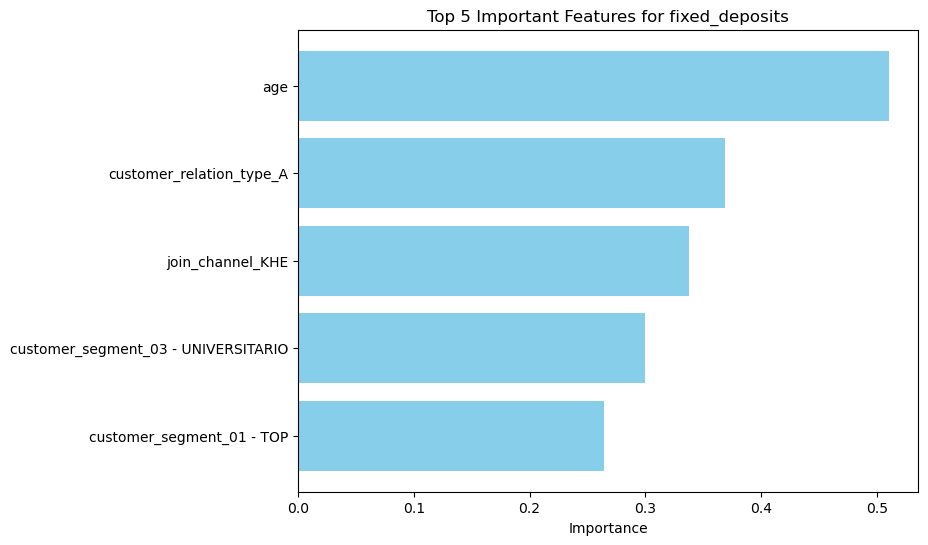

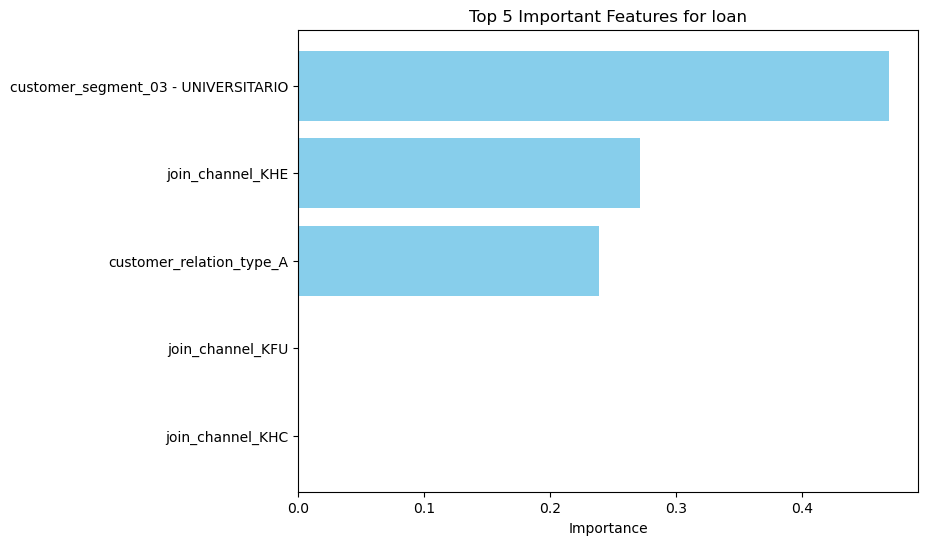

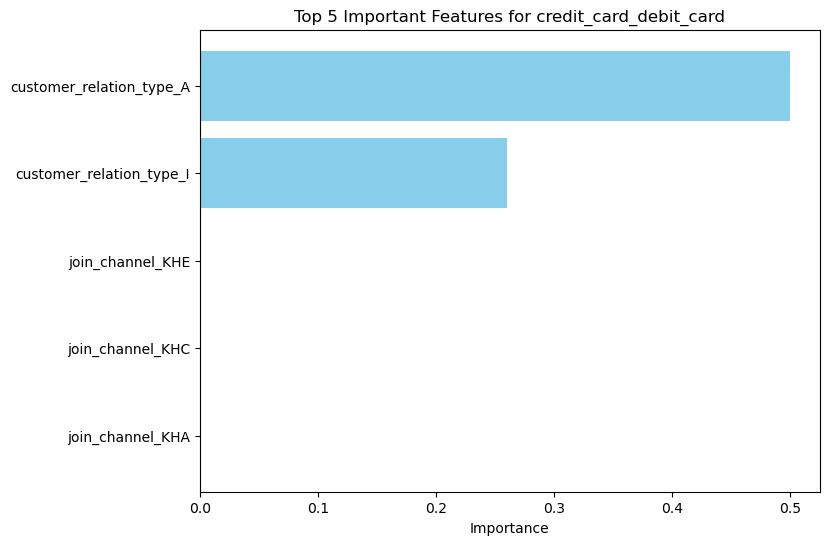

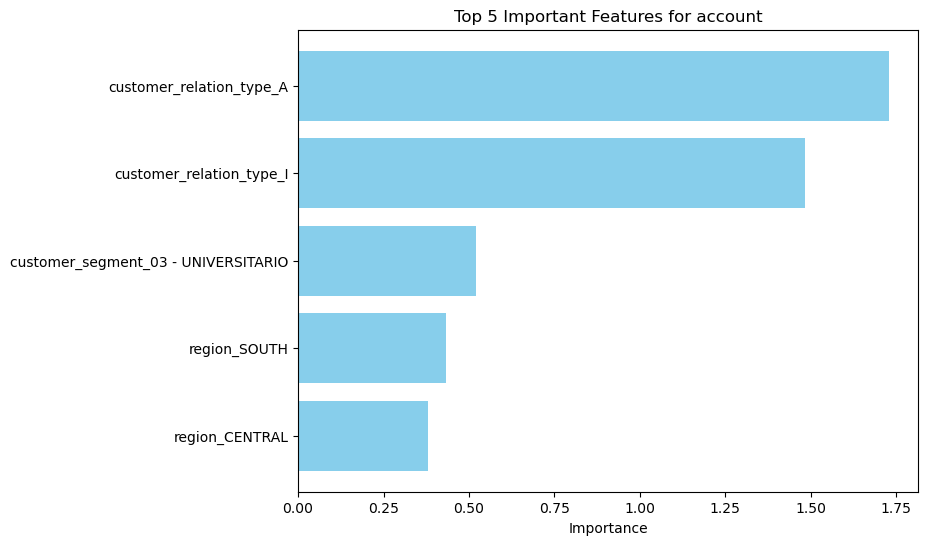

In [140]:
# Assuming the `models` dictionary has been created by train_and_evaluate_models
# and contains trained logistic regression models for each target column.

def plot_top_features(models, feature_names, top_n=5):
    """
    Plots the top N important features for each model in the models dictionary.
    
    Parameters:
    - models: Dictionary of trained models for each target column
    - feature_names: List of feature names in the original dataset
    - top_n: Number of top features to plot (default is 5)
    """
    for column_name, model in models.items():
        # Extract feature importances (coefficients) for the logistic regression model
        coefficients = np.abs(model.coef_[0])  # Get the absolute values of the coefficients
        feature_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': coefficients
        })
        
        # Sort and get top N important features
        top_features = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)
        
        # Plot the top features for this model
        plt.figure(figsize=(8, 6))
        plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Important Features for {column_name}')
        plt.gca().invert_yaxis()  # Highest importance at the top
        plt.show()


feature_names = df_test.drop(columns=['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']).columns

# Plot the top features
plot_top_features(models, feature_names)


### Model training and evaluation

## 5) Model implementation, performance metrics and intepretation of other scenarios
1. Covid 
2. Meteor 

### 5.1) Covid


Training and evaluating model for fixed_deposits
Best parameters for fixed_deposits: {'penalty': 'l2', 'C': 0.001}
Recall for fixed_deposits at threshold 0.05: 1.0000
Accuracy for fixed_deposits at threshold 0.05: 0.4688
Recall for fixed_deposits at threshold 0.10: 0.9974
Accuracy for fixed_deposits at threshold 0.10: 0.6198
Recall for fixed_deposits at threshold 0.15: 0.9922
Accuracy for fixed_deposits at threshold 0.15: 0.7209
Recall for fixed_deposits at threshold 0.20: 0.9922
Accuracy for fixed_deposits at threshold 0.20: 0.7694
Recall for fixed_deposits at threshold 0.25: 0.9741
Accuracy for fixed_deposits at threshold 0.25: 0.8045
Recall for fixed_deposits at threshold 0.30: 0.9689
Accuracy for fixed_deposits at threshold 0.30: 0.8244
Recall for fixed_deposits at threshold 0.35: 0.9611
Accuracy for fixed_deposits at threshold 0.35: 0.8419
Recall for fixed_deposits at threshold 0.40: 0.9275
Accuracy for fixed_deposits at threshold 0.40: 0.8592
Recall for fixed_deposits at thresho

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


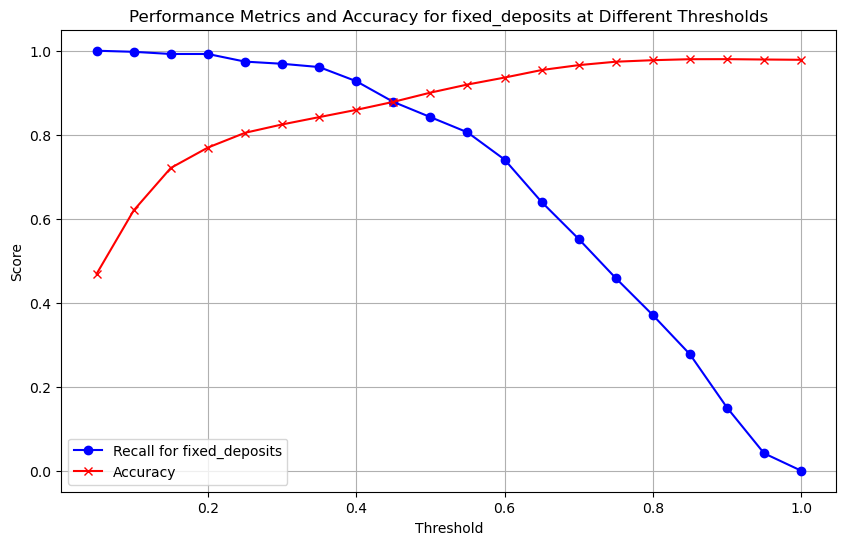

Evaluating model for fixed_deposits at fixed threshold 0.50
Confusion Matrix for fixed_deposits at threshold 0.50:
[[15763  1723]
 [   61   325]]
Recall for fixed_deposits at threshold 0.50: 0.8420
Accuracy for fixed_deposits at threshold 0.50: 0.9002

Training and evaluating model for loan


/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for loan: {'penalty': 'l1', 'C': 0.001}
Recall for loan at threshold 0.05: 1.0000
Accuracy for loan at threshold 0.05: 0.0022
Recall for loan at threshold 0.10: 1.0000
Accuracy for loan at threshold 0.10: 0.0022
Recall for loan at threshold 0.15: 1.0000
Accuracy for loan at threshold 0.15: 0.0022
Recall for loan at threshold 0.20: 1.0000
Accuracy for loan at threshold 0.20: 0.5370
Recall for loan at threshold 0.25: 0.9750
Accuracy for loan at threshold 0.25: 0.6900
Recall for loan at threshold 0.30: 0.9750
Accuracy for loan at threshold 0.30: 0.7114
Recall for loan at threshold 0.35: 0.9750
Accuracy for loan at threshold 0.35: 0.7433
Recall for loan at threshold 0.40: 0.9750
Accuracy for loan at threshold 0.40: 0.7433
Recall for loan at threshold 0.45: 0.9250
Accuracy for loan at threshold 0.45: 0.7806
Recall for loan at threshold 0.50: 0.9250
Accuracy for loan at threshold 0.50: 0.7945
Recall for loan at threshold 0.55: 0.9250
Accuracy for loan at threshold 0.55: 0.835

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


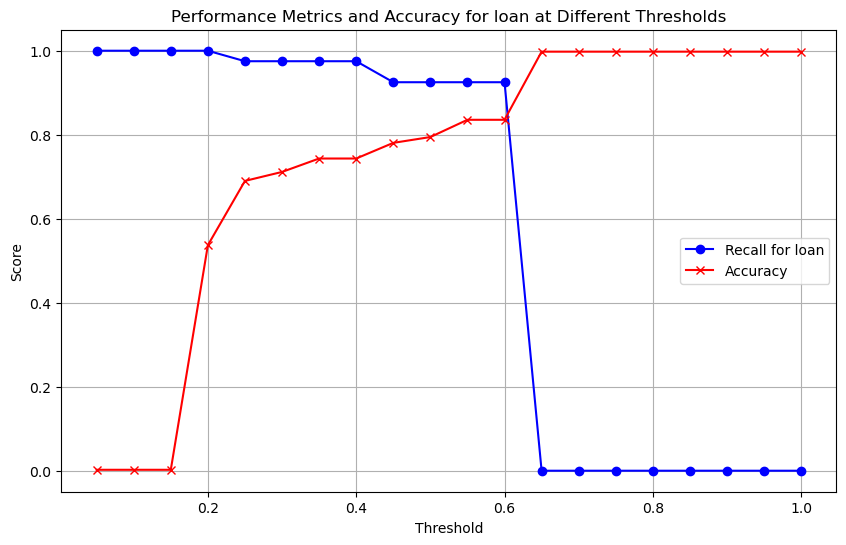

Evaluating model for loan at fixed threshold 0.50
Confusion Matrix for loan at threshold 0.50:
[[14162  3670]
 [    3    37]]
Recall for loan at threshold 0.50: 0.9250
Accuracy for loan at threshold 0.50: 0.7945

Training and evaluating model for credit_card_debit_card
Best parameters for credit_card_debit_card: {'penalty': 'l1', 'C': 0.001}
Recall for credit_card_debit_card at threshold 0.05: 1.0000
Accuracy for credit_card_debit_card at threshold 0.05: 0.1030
Recall for credit_card_debit_card at threshold 0.10: 1.0000
Accuracy for credit_card_debit_card at threshold 0.10: 0.1030
Recall for credit_card_debit_card at threshold 0.15: 1.0000
Accuracy for credit_card_debit_card at threshold 0.15: 0.1030
Recall for credit_card_debit_card at threshold 0.20: 1.0000
Accuracy for credit_card_debit_card at threshold 0.20: 0.1030
Recall for credit_card_debit_card at threshold 0.25: 0.9674
Accuracy for credit_card_debit_card at threshold 0.25: 0.7254
Recall for credit_card_debit_card at threshold

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


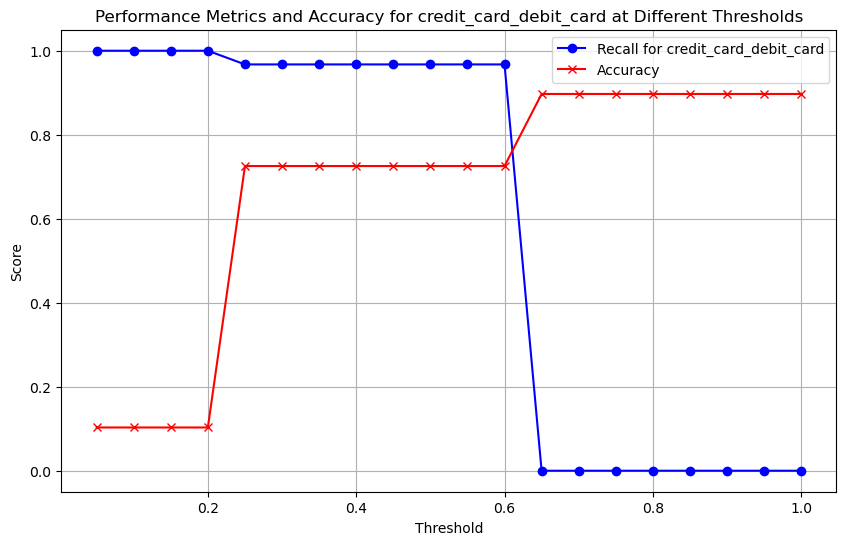

Evaluating model for credit_card_debit_card at fixed threshold 0.50
Confusion Matrix for credit_card_debit_card at threshold 0.50:
[[11185  4847]
 [   60  1780]]
Recall for credit_card_debit_card at threshold 0.50: 0.9674
Accuracy for credit_card_debit_card at threshold 0.50: 0.7254

Training and evaluating model for account
Best parameters for account: {'penalty': 'l1', 'C': 1}
Specificity for account at threshold 0.05: 0.0038
Accuracy for account at threshold 0.05: 0.9846
Specificity for account at threshold 0.10: 0.0038
Accuracy for account at threshold 0.10: 0.9846
Specificity for account at threshold 0.15: 0.0038
Accuracy for account at threshold 0.15: 0.9844
Specificity for account at threshold 0.20: 0.0038
Accuracy for account at threshold 0.20: 0.9842
Specificity for account at threshold 0.25: 0.0038
Accuracy for account at threshold 0.25: 0.9842
Specificity for account at threshold 0.30: 0.0038
Accuracy for account at threshold 0.30: 0.9839
Specificity for account at threshold

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


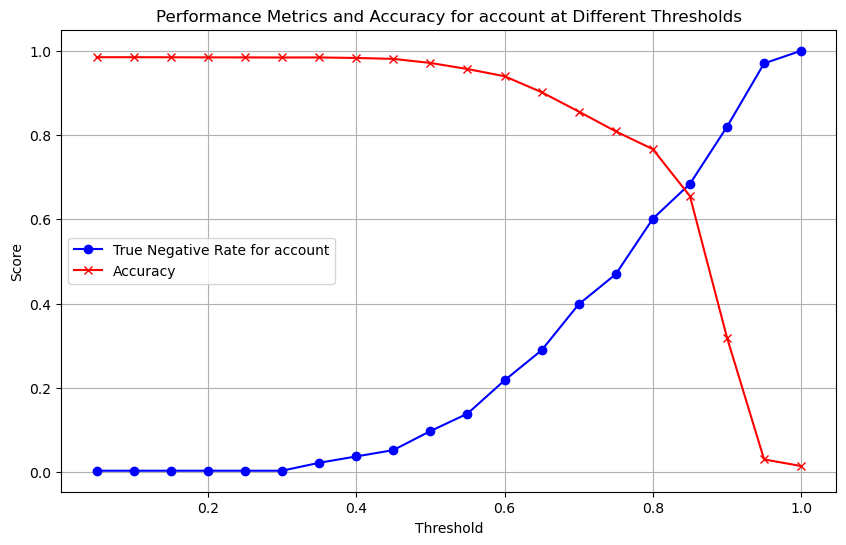

Evaluating model for account at fixed threshold 0.80
Confusion Matrix for account at threshold 0.80:
[[  160   106]
 [ 4068 13538]]
Specificity for account at threshold 0.80: 0.6015
Accuracy for account at threshold 0.80: 0.7665


In [141]:
covid_models = train_and_evaluate_models(balanced_covid_train, df_covid_test)


### Finding features that are key to customer decision (Covid)

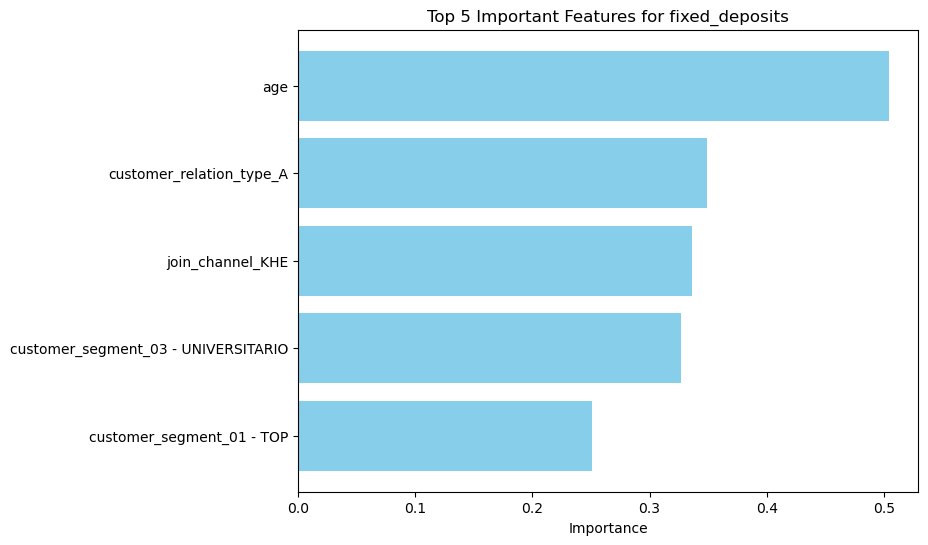

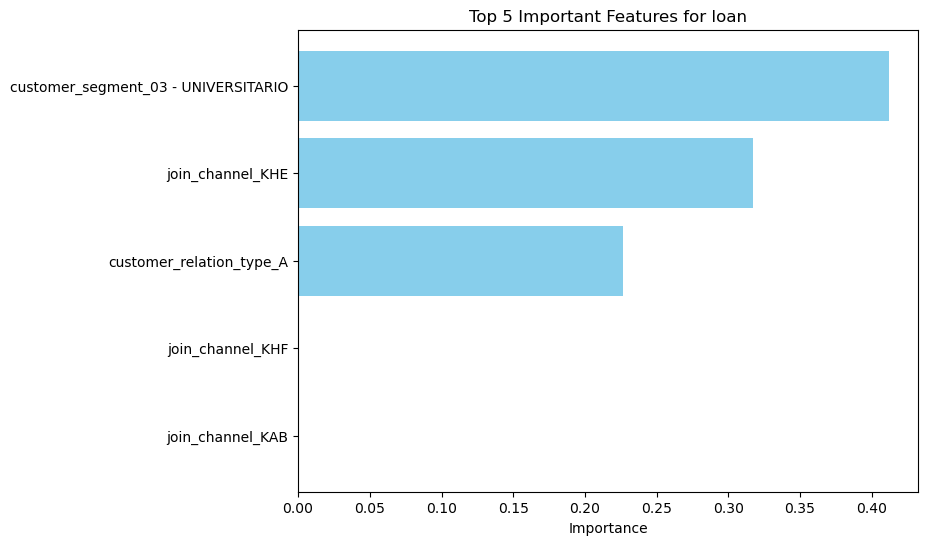

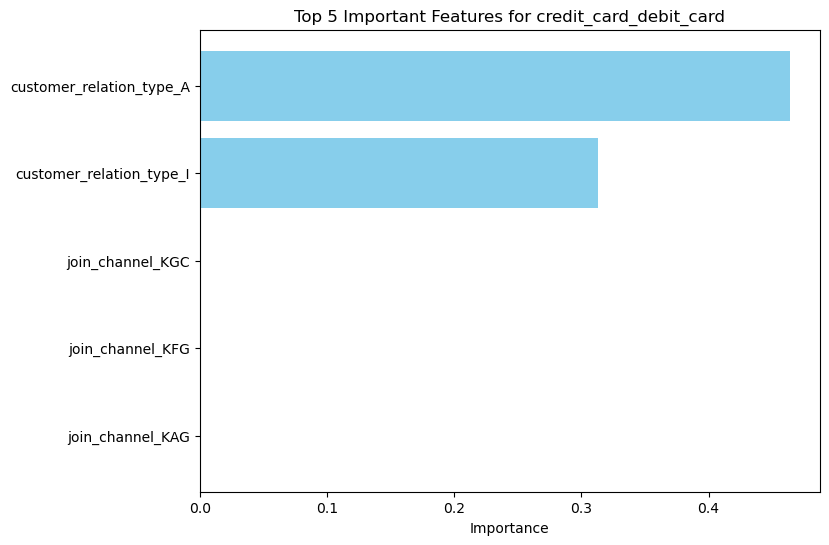

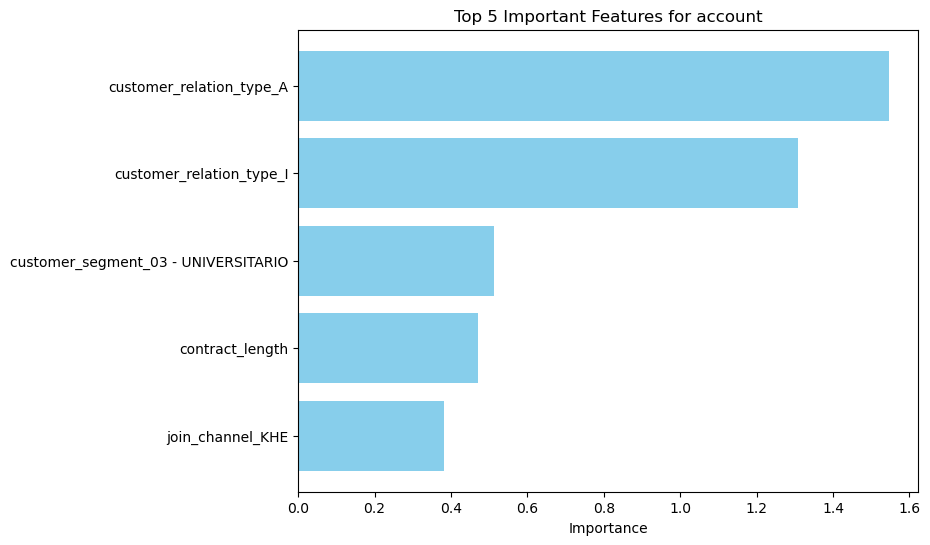

In [144]:
covid_feature_names = df_covid_test.drop(columns=['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']).columns
plot_top_features(covid_models, covid_feature_names)

### 5.2) Meteor


Training and evaluating model for fixed_deposits
Best parameters for fixed_deposits: {'penalty': 'l2', 'C': 0.001}
Recall for fixed_deposits at threshold 0.05: 1.0000
Accuracy for fixed_deposits at threshold 0.05: 0.4707
Recall for fixed_deposits at threshold 0.10: 0.9974
Accuracy for fixed_deposits at threshold 0.10: 0.6205
Recall for fixed_deposits at threshold 0.15: 0.9922
Accuracy for fixed_deposits at threshold 0.15: 0.7217
Recall for fixed_deposits at threshold 0.20: 0.9922
Accuracy for fixed_deposits at threshold 0.20: 0.7693
Recall for fixed_deposits at threshold 0.25: 0.9741
Accuracy for fixed_deposits at threshold 0.25: 0.8046
Recall for fixed_deposits at threshold 0.30: 0.9689
Accuracy for fixed_deposits at threshold 0.30: 0.8245
Recall for fixed_deposits at threshold 0.35: 0.9611
Accuracy for fixed_deposits at threshold 0.35: 0.8421
Recall for fixed_deposits at threshold 0.40: 0.9275
Accuracy for fixed_deposits at threshold 0.40: 0.8590
Recall for fixed_deposits at thresho

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


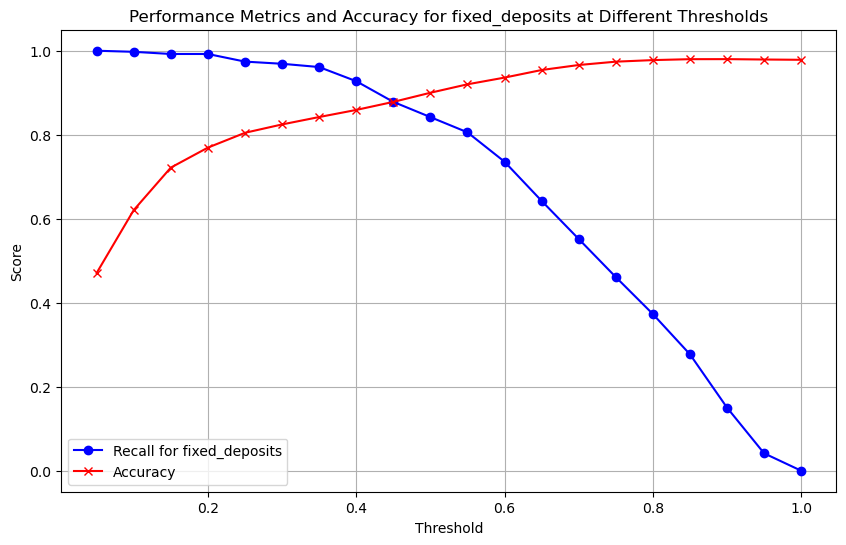

Evaluating model for fixed_deposits at fixed threshold 0.50
Confusion Matrix for fixed_deposits at threshold 0.50:
[[15758  1728]
 [   61   325]]
Recall for fixed_deposits at threshold 0.50: 0.8420
Accuracy for fixed_deposits at threshold 0.50: 0.8999

Training and evaluating model for loan


/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters for loan: {'penalty': 'l1', 'C': 0.001}
Recall for loan at threshold 0.05: 1.0000
Accuracy for loan at threshold 0.05: 0.0022
Recall for loan at threshold 0.10: 1.0000
Accuracy for loan at threshold 0.10: 0.0022
Recall for loan at threshold 0.15: 1.0000
Accuracy for loan at threshold 0.15: 0.0022
Recall for loan at threshold 0.20: 1.0000
Accuracy for loan at threshold 0.20: 0.5370
Recall for loan at threshold 0.25: 0.9750
Accuracy for loan at threshold 0.25: 0.6900
Recall for loan at threshold 0.30: 0.9750
Accuracy for loan at threshold 0.30: 0.7114
Recall for loan at threshold 0.35: 0.9750
Accuracy for loan at threshold 0.35: 0.7433
Recall for loan at threshold 0.40: 0.9750
Accuracy for loan at threshold 0.40: 0.7433
Recall for loan at threshold 0.45: 0.9250
Accuracy for loan at threshold 0.45: 0.7806
Recall for loan at threshold 0.50: 0.9250
Accuracy for loan at threshold 0.50: 0.7945
Recall for loan at threshold 0.55: 0.9250
Accuracy for loan at threshold 0.55: 0.835

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


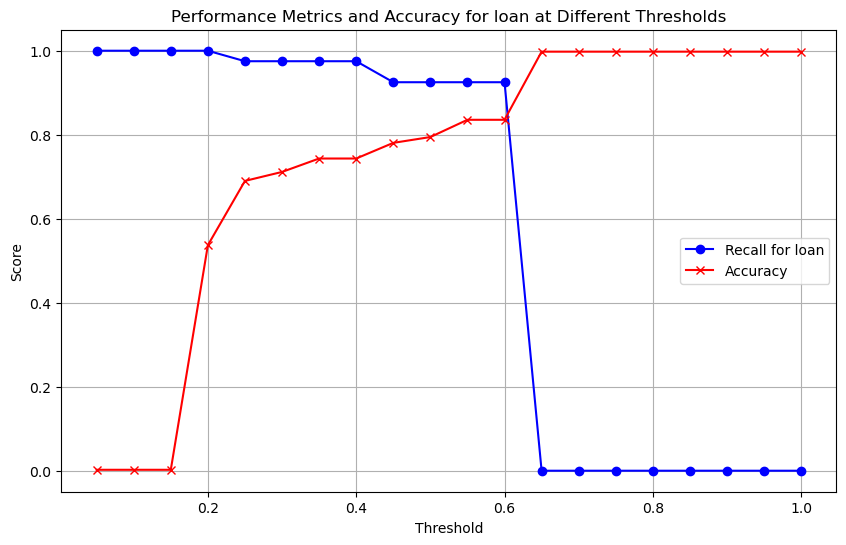

Evaluating model for loan at fixed threshold 0.50
Confusion Matrix for loan at threshold 0.50:
[[14162  3670]
 [    3    37]]
Recall for loan at threshold 0.50: 0.9250
Accuracy for loan at threshold 0.50: 0.7945

Training and evaluating model for credit_card_debit_card
Best parameters for credit_card_debit_card: {'penalty': 'l1', 'C': 0.001}
Recall for credit_card_debit_card at threshold 0.05: 1.0000
Accuracy for credit_card_debit_card at threshold 0.05: 0.1030
Recall for credit_card_debit_card at threshold 0.10: 1.0000
Accuracy for credit_card_debit_card at threshold 0.10: 0.1030
Recall for credit_card_debit_card at threshold 0.15: 1.0000
Accuracy for credit_card_debit_card at threshold 0.15: 0.1030
Recall for credit_card_debit_card at threshold 0.20: 1.0000
Accuracy for credit_card_debit_card at threshold 0.20: 0.1030
Recall for credit_card_debit_card at threshold 0.25: 0.9674
Accuracy for credit_card_debit_card at threshold 0.25: 0.7254
Recall for credit_card_debit_card at threshold

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


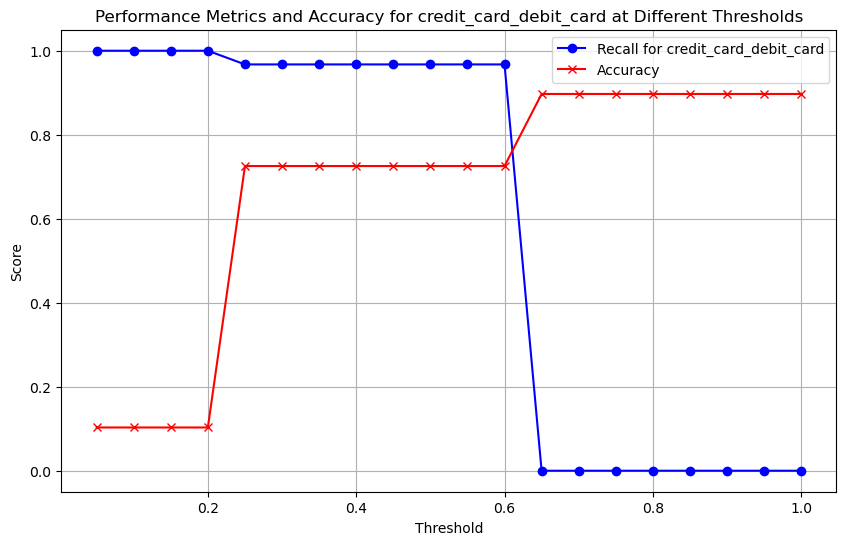

Evaluating model for credit_card_debit_card at fixed threshold 0.50
Confusion Matrix for credit_card_debit_card at threshold 0.50:
[[11185  4847]
 [   60  1780]]
Recall for credit_card_debit_card at threshold 0.50: 0.9674
Accuracy for credit_card_debit_card at threshold 0.50: 0.7254

Training and evaluating model for account
Best parameters for account: {'penalty': 'l1', 'C': 1}
Specificity for account at threshold 0.05: 0.0038
Accuracy for account at threshold 0.05: 0.9846
Specificity for account at threshold 0.10: 0.0038
Accuracy for account at threshold 0.10: 0.9846
Specificity for account at threshold 0.15: 0.0038
Accuracy for account at threshold 0.15: 0.9844
Specificity for account at threshold 0.20: 0.0038
Accuracy for account at threshold 0.20: 0.9842
Specificity for account at threshold 0.25: 0.0038
Accuracy for account at threshold 0.25: 0.9842
Specificity for account at threshold 0.30: 0.0038
Accuracy for account at threshold 0.30: 0.9839
Specificity for account at threshold

/Users/collinsng/anaconda3/envs/DSA3101/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


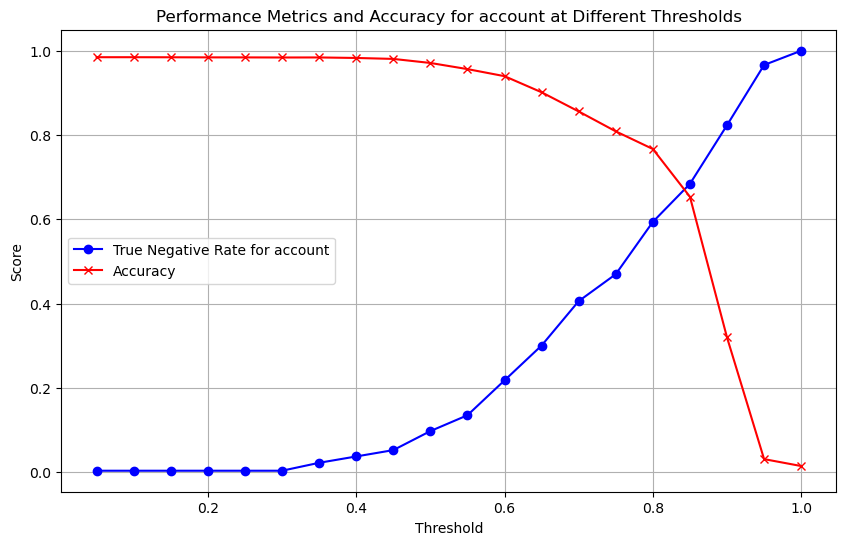

Evaluating model for account at fixed threshold 0.80
Confusion Matrix for account at threshold 0.80:
[[  158   108]
 [ 4059 13547]]
Specificity for account at threshold 0.80: 0.5940
Accuracy for account at threshold 0.80: 0.7668


In [145]:
meteor_models = train_and_evaluate_models(balanced_meteor_train, df_meteor_test)

### Finding features that are key to customer decision (Meteor)

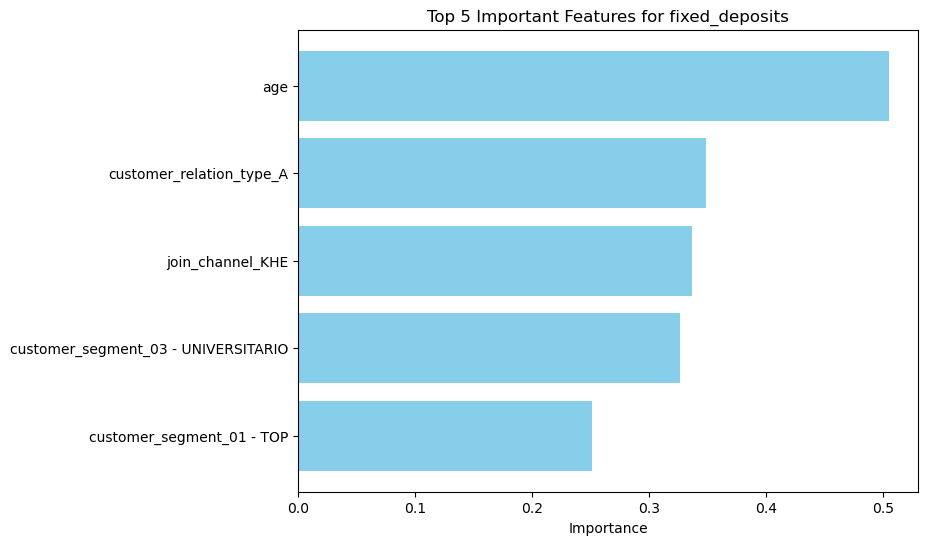

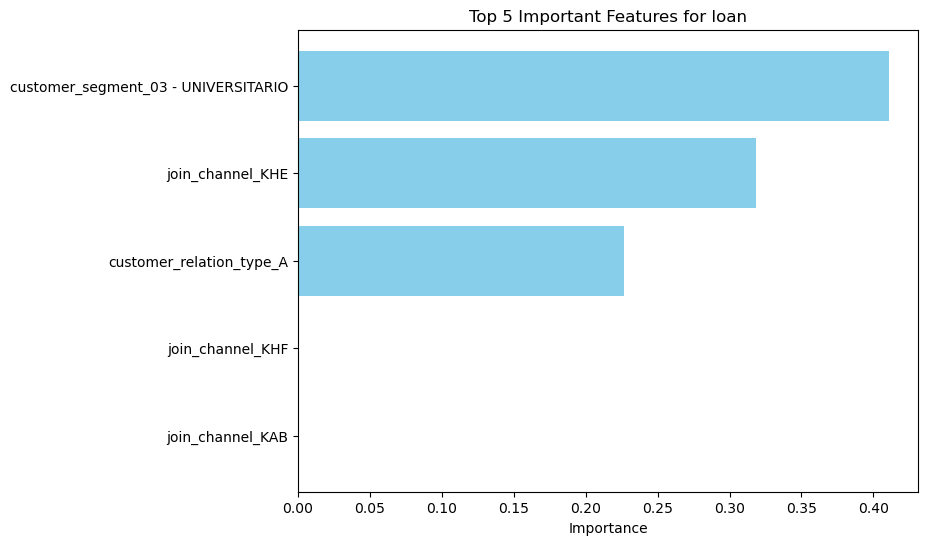

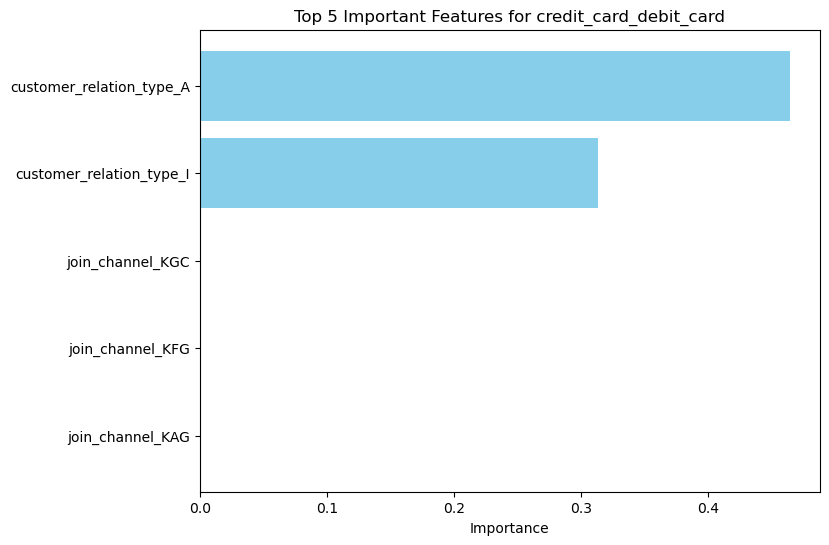

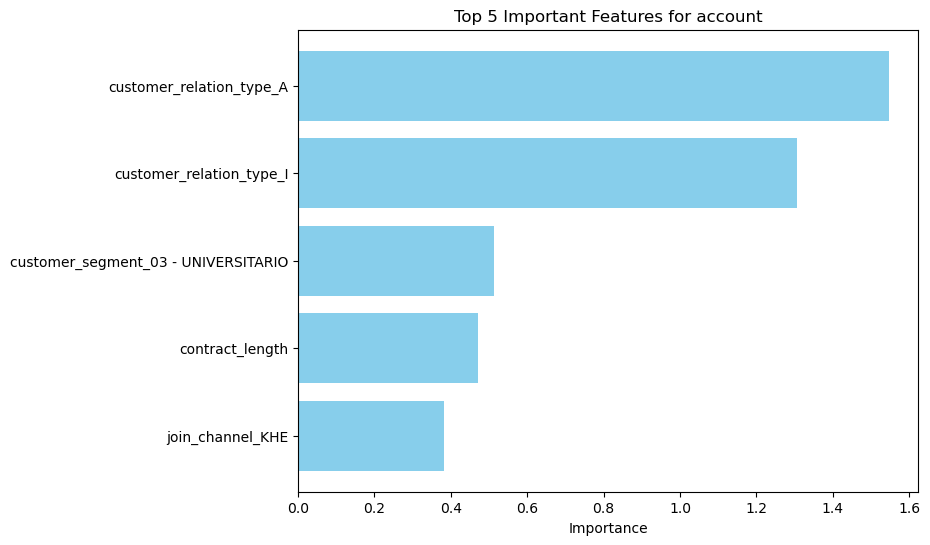

In [146]:
meteor_feature_names = df_meteor_test.drop(columns=['fixed_deposits', 'loan', 'credit_card_debit_card', 'account']).columns
plot_top_features(meteor_models, meteor_feature_names)

## 6) Evaluation of model performance against business objectives
WIP points:  
(1) By choosing the right thresholds, we can get good key performance metrics without sacrificing general performance.   
(2) logistic regression shows general success, better than random guessing  

This section includes:
1. The choice of performance metrics to fit business objectives
2. Summary report of model performance and results evaluation


**(1) The right choice of performance metrics to fit business objectives:**  
As we have observed from the data, the products 'fixed_deposits', 'loan', 'credit_card_debit_card' are rarely purchased by customers (hereby referred to as subscription rate, and this case these 3 products have a low subscription rate), while the subscription rate for account is high. 

For a high subscription rate, most customers already have the product and we would not want to waste funds advertising to these customers. In addition for the customers who do not yet have this product, they are very likely to have heard of the product through word of mouth from the rest of the people already have the product. Hence in this situation we are interested in avoiding uneccessary marketing of the product to those who do not want it. Unecessary advertisements may annoy the customer (an issue outlined in the problem statment). Hence we are use specificity when dealing with the logistic regression model for account, which is the True Negative Rate (TNR) which is calculated by: True Negative (TN), False Positive (FP)
TNR = TN / (TN + FP)  
This metric rewards correct guesses for customers who do not want the product (True negatives) while punishing the model for wrongly assuming customers want the product when they do not (False Positives)  

For the products with a low subscription rate: ‘fixed_deposits’, ‘loan’, and ‘credit_card_debit_card’, we are interested in maximizing the True Positive Rate (TPR), also known as Recall. This is calculated by: True Positive (TP), False Negative (FN)  
TPR = TP / (TP + FN)   
This metric captures the proportion of actual subscribers that the model correctly identifies as wanting the product. Since only a small fraction of customers are likely to want these products, our primary objective is to accurately identify these few interested customers to ensure we can target them effectively. Missing these interested customers would mean lost revenue opportunities for the bank. In this situation, we want to reward the model for correctly identifying interested customers (True Positives), while penalizing it for failing to recognize customers who would subscribe to the product (False Negatives).  

It is important to note that while focusing on metrics like TNR for high subscription products and TPR (or recall) for low subscription products, it's important to also report accuracy alongside those metrics. Accuracy provides a general view of the model's overall performance, reflecting its ability to make correct predictions across both positive and negative classes. For high subscription rate products, accuracy ensures that TNR improvements do not come at the expense of general performance. For low subscription rate products, accuracy helps avoid overfitting to recall by balancing the correct classification of both interested and uninterested customers.